# Clasificación de Noticias por Categoría
## Objetivo
Entrenar un modelo de NLP para clasificar textos de noticias en categorias como politica, deportes, tecnologia, religion, ciencia, etc., usando el dataset 20 Newsgroups

In [15]:
# Importo librerias
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carga datos de entrenamiento
data_source = fetch_20newsgroups(subset = 'train', remove=('headers','footers','quotes'))
print(data_source.target_names) # Muestra las 20 categorias

print(data_source.data[0])      # Muestra un ejemplo del texto

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


Este dataset contiene miles de textos agrupados en 20 categorias tematicas.

## Vectorizacion con TF-IDF

In [4]:
# TF-IDF: convierte los textos en vectores numericos, ponderando la relevancia de cada palabra
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(data_source.data)
y = data_source.target

## Divido en variables de entrenamiento y prueba

In [6]:
X_entrena, X_prueba, y_entrena, y_prueba = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Entrenamiento de modelos

In [8]:
# Naive Bayes suele funcionar muy bien en texto por su simplicidad y eficiencia.
# Logistic Regression puede capturar relaciones más complejas
modelos = [
    ('Naive Bayes', MultinomialNB()),
    ('Logistic Regression', LogisticRegression(max_iter=10000))
]

for nombre, modelo in modelos:
    modelo.fit(X_entrena, y_entrena)
    score = modelo.score(X_prueba, y_prueba)
    print(f'{nombre}: Accuracy = {score*100:.2f}%')

Naive Bayes: Accuracy = 68.76%
Logistic Regression: Accuracy = 70.22%


## Matriz de confusión y clasificación por categoría

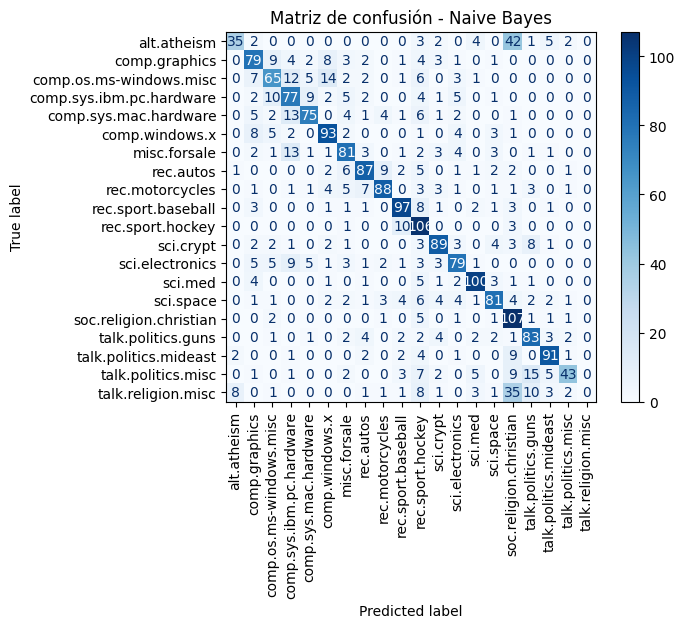

In [12]:
modelo_nb = modelos[0][1]
y_prediccion = modelo_nb.predict(X_prueba)

cm = confusion_matrix(y_prueba, y_prediccion)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data_source.target_names)
disp.plot(cmap = 'Blues', xticks_rotation = 90)
plt.title('Matriz de confusión - Naive Bayes')
plt.show()

## ¿Qué categorias se clasifican mejor?
Con el siguiente reporte por clase se podra ver la precision, el recall y F1-score por categoria.

Las categorias con mayor F1-score son las que el modelo clasifica mejor.

In [18]:
# Usando el modelo de Naive Bayes como ejemplo
y_prediccion = modelo_nb.predict(X_prueba)

# Reporte por clase
print(classification_report(y_prueba, y_prediccion, target_names=data_source.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.76      0.36      0.49        96
           comp.graphics       0.65      0.68      0.66       117
 comp.os.ms-windows.misc       0.62      0.55      0.59       118
comp.sys.ibm.pc.hardware       0.57      0.65      0.61       118
   comp.sys.mac.hardware       0.76      0.65      0.70       115
          comp.windows.x       0.71      0.78      0.74       119
            misc.forsale       0.68      0.69      0.68       117
               rec.autos       0.76      0.73      0.74       119
         rec.motorcycles       0.81      0.73      0.77       120
      rec.sport.baseball       0.77      0.82      0.79       119
        rec.sport.hockey       0.55      0.88      0.68       120
               sci.crypt       0.75      0.75      0.75       119
         sci.electronics       0.71      0.67      0.69       118
                 sci.med       0.83      0.84      0.84       119
         

Las categorias que se clasifican mejor son:
* sci.med
* rec.sport.baseball
* rec.motorcycles

Al analizar el rendimiento por clase, observé que categorías como ‘sci.med’, ‘rec.sport.baseball’ y ‘rec.motorcycles’ se clasifican con mayor precisión, alcanzando f1-scores superiores a 0.75. Esto sugiere que el vocabulario en esas clases es más distintivo. En contraste, categorías como ‘talk.religion.misc’ y ‘alt.atheism’ presentan bajo rendimiento, posiblemente por compartir vocabulario con otras clases o tener textos más ambiguos. Este análisis me permitió entender cómo el modelo se comporta en escenarios multiclase y qué ajustes podrían mejorar su capacidad de discriminación.

## ¿Qué palabras son más discriminantes?

Aquí si estoy usando Regresion Logística, puedo acceder a los coeficientes del modelo y vincularlos con las palabras del vectorizador.

También se debe entender que una palabra es discriminante, cuando ayuda al modelo a distinguir una categoria de las demás. Es decir que aparece con mucha frecuencia en una clase específica y con poca frecuencia en otras.

In [23]:
modelo_lr = modelos[1][1]
feature_names = vectorizer.get_feature_names_out()

# Para cada clase mostrar las palabras con mayor peso

for i, clase in enumerate(data_source.target_names):
    top_indices = np.argsort(modelo_lr.coef_[i])[-10:] # Solo top 10 palabras

    top_words = feature_names[top_indices]
    print(f'Categoria: {clase}')
    print(f'Palabras mas discriminantes: "{top_words}"')
    print()

Categoria: alt.atheism
Palabras mas discriminantes: "['morality' 'bible' 'atheist' 'islamic' 'bobby' 'atheists' 'god' 'islam'
 'atheism' 'religion']"

Categoria: comp.graphics
Palabras mas discriminantes: "['points' 'cview' 'vesa' 'format' 'polygon' 'files' 'images' '3d' 'image'
 'graphics']"

Categoria: comp.os.ms-windows.misc
Palabras mas discriminantes: "['risc' 'files' 'dos' 'win' 'fonts' 'problem' 'cica' 'ax' 'file' 'windows']"

Categoria: comp.sys.ibm.pc.hardware
Palabras mas discriminantes: "['bios' 'drive' 'port' 'ide' 'bus' 'controller' 'pc' 'scsi' 'monitor'
 'card']"

Categoria: comp.sys.mac.hardware
Palabras mas discriminantes: "['nubus' 'simms' 'centris' 'lc' 'drive' 'quadra' 'powerbook' 'se' 'apple'
 'mac']"

Categoria: comp.windows.x
Palabras mas discriminantes: "['openwindows' 'application' 'widgets' 'x11r5' 'mit' 'xterm' 'widget'
 'server' 'motif' 'window']"

Categoria: misc.forsale
Palabras mas discriminantes: "['looking' 'price' 'email' 'interested' '00' 'condition' '

Con el codigo anterior, se puede pensar y responder otra pregunta:

**¿Todas las palabras que se visualizan son discriminantes?**

* La respuesta es sí **pero solo dentro de su categoria**. Cuando se determinó el top 10 de palabras, se le dice al programa que solo muestre las 10 más discriminantes por categoria, en báse a los coeficientes del modelo.

Las palabras más discriminantes varían según la categoría. Al analizar los coeficientes del modelo, observé que términos como ‘orbit’ y ‘nasa’ son clave para identificar textos de ciencia espacial, mientras que ‘goal’ y ‘nhl’ destacan en deportes. Este análisis me permitió entender cómo el modelo aprende a separar clases en problemas multiclase de NLP, y cómo el vocabulario específico impacta directamente en la capacidad de clasificación.

# 📰 Caso práctico: Clasificación de noticias por categoría

### 🎯 Objetivo
Entrenar un modelo de NLP para clasificar textos de noticias en 20 categorías temáticas (como política, deportes, tecnología, religión, ciencia), utilizando técnicas de vectorización y modelos supervisados multiclase.

---

### 🧪 Pasos realizados

- Carga del dataset `20 Newsgroups` desde `sklearn.datasets`
- Eliminación de encabezados, pies y citas para reducir ruido
- Vectorización de texto con TF-IDF (`max_features=5000`, `stop_words='english'`)
- División en entrenamiento y prueba (`test_size=0.2`, `stratify=y`)
- Entrenamiento de modelos: Naive Bayes y Regresión Logística
- Evaluación con accuracy, matriz de confusión y reporte por clase
- Análisis de palabras más discriminantes por categoría usando coeficientes
- Reflexión sobre el comportamiento del modelo y las clases más difíciles

---

### 📊 Resultados

| Modelo              | Accuracy (%) |
|---------------------|--------------|
| Naive Bayes         | 68.76        |
| Logistic Regression | 70.22        |

- Regresión Logística mostró mejor rendimiento general y mayor capacidad de interpretación.
- Categorías como `sci.med`, `rec.sport.baseball` y `rec.motorcycles` alcanzaron f1-scores superiores a 0.75.
- Categorías como `talk.religion.misc` y `alt.atheism` presentaron bajo rendimiento, posiblemente por vocabulario ambiguo o solapado.
- Palabras como `orbit`, `nhl`, `treatment`, `government` fueron altamente discriminantes dentro de sus respectivas clases.

---

### 💬 Reflexión

> “Este ejercicio me permitió aplicar técnicas de procesamiento de lenguaje natural para abordar un problema de clasificación multiclase. Al vectorizar el texto con TF-IDF y entrenar modelos como Naive Bayes y Regresión Logística, pude observar cómo el vocabulario específico de cada categoría influye directamente en la capacidad del modelo para distinguir entre clases. El análisis por clase reveló que temas como medicina y deportes tienen vocabulario más distintivo, mientras que religión y política presentan mayor ambigüedad. Este tipo de ejercicio me ayudó a conectar el preprocesamiento textual con el rendimiento del modelo, y a interpretar los coeficientes como una herramienta para explicar decisiones algorítmicas.”

---

### 📎 Recursos utilizados

- Dataset: `20 Newsgroups` (`sklearn.datasets`)
- Librerías: `Scikit-Learn`, `Matplotlib`, `NumPy`
- Entorno: `Jupyter Notebook`

---

### 📂 Estructura del proyecto

<>
/news_classification/ │ ├── noticias_model.ipynb ├── README.md ├── resultados/ │   ├── matriz_confusion_nb.png │   ├── matriz_confusion_lr.png │   ├── palabras_discriminantes_por_categoria.txt │   └── reporte_por_clase.txt
